In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np
import torch as pt
import torch.nn as nn

import types
import numbers

# pt.autograd.set_detect_anomaly(False)

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    pt.manual_seed(seed)
    pt.cuda.manual_seed_all(seed)
    pt.backends.cudnn.deterministic = True
    pt.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
def V_step(V, F):
    phi = F[0]  # linear acceleration
    psi = F[1]  # angluar acceleration
    dt = F[2]   # timestep size
    dt2 = dt*dt/2

    x = V[0]    # x coordinate
    y = V[1]    # y coordinate
    a = V[2]    # angle
    s = V[3]    # speed
    w = V[4]    # angular speed
    t = V[5]    # time

    _0 = pt.zeros_like(x)
    _1 = pt.ones_like(x)

    A1 = pt.stack([x, y, a, s, w, t])
    A2 = pt.stack([s*pt.cos(a), s*pt.sin(a), w, _0, _0, _0])
    A3 = pt.stack([-s*w*pt.sin(a), s*w*pt.cos(a), _0, _0, _0, _0])
    A = A1 + dt*A2 + dt2*A3

    B2 = pt.stack([_0, _0, _0, _1, _0, _0])
    B3 = pt.stack([pt.cos(a), pt.sin(a), _0, _0, _0, _0])
    B = dt*B2 + dt2*B3

    C2 = pt.stack([_0, _0, _0, _0, _1, _0])
    C3 = pt.stack([_0, _0, _1, _0, _0, _0])
    C = dt*C2 + dt2*C3

    D = pt.stack([_0, _0, _0, _0, _0, _1])  # this is correct

    # V1 = A + phi*B + psi*C + dt*D
    # return pt.clamp(V1,
    #     min=pt.tensor([-pt.inf, -pt.inf, -pt.inf, 0, -2, -pt.inf]),
    #     max=pt.tensor([pt.inf, pt.inf, pt.inf, pt.inf, 2, pt.inf]))

    return A + phi*B + psi*C + dt*D

def angle_diff(theta1, theta2):
    diff = theta1 - theta2
    return (diff + np.pi) % (2 * np.pi) - np.pi

def get_forcing(V, F):
    # limits based on current speed
    limits_min = pt.tensor([-0.8, -0.8, 0.001], device=F.device)
    limits_max = pt.tensor([0.8, 0.8, 0.25], device=F.device)
    return limits_min + (limits_max - limits_min) * pt.sigmoid(F)

def to_tensor(V_mat):
    ten = pt.zeros((len(V_mat), V_mat[0].shape[0]))
    for i in range(len(V_mat)):
        ten[i] = V_mat[i].detach().cpu()
    return ten[:,0:5], ten[:,5]

def to_lambda(schedule):
    if schedule is None:
        return lambda x, target_loss: 0
    if isinstance(schedule, numbers.Number):
        return lambda x, target_loss: schedule
    if callable(schedule):
        return schedule
    raise TypeError(f'Invalid schedule type: {type(schedule)}. Expected None, a number, or a function.')

In [4]:
def multi_loss_fun(Y, T, F, scale=None):
    """
    Y: final state (6D: x, y, theta, s, omega, t)
    T: target (2D or 5D)
    F: list of forcings
    """
    scale = pt.tensor([1, 1, 1, 1, 1]) if scale is None else scale
    diff = (Y[0:5]-T[0:5])
    diff[2] = angle_diff(Y[2], T[2])
    position_loss = pt.sum(diff * diff * scale)       # loss from missing the target
    time_loss = Y[5]                                # loss by taking too long
    l2_loss = pt.mean(pt.stack(F)[:,0:2]**2)        # loss by using too much force
    return position_loss, time_loss, l2_loss


def compute_multi_path_autograd(V0, F_logits, target):
    V_list = [V0]    # trajectory as a list of position vectors
    F_true = []      # forcing terms as a list of forcing vectors

    for i in range(F_logits.shape[0]):
        F_true.append(get_forcing(V_list[-1], F_logits[i]))
        V_list.append(V_step(V_list[i], F_true[i]))

    loss = multi_loss_fun(V_list[-1], target, F_true, scale=pt.tensor([1, 1, 1, 1, 1]))

    return V_list, loss

In [5]:
def optimizeMultiPath(v0, checkpoint_2d, target, checkpoint_dof, F_logits, iters=500, fine_tuning_steps=50, plot_freq=50,
        lr=9e-2, l2_rate=-1e0, time_rate=2e-8, reverse_rate=0.5, continuity_rate=0.5, sign_rate=0.25
    ):
    """
    v0: starting tensor in 6d (v0[5]=0)
    checkpoint_2d: num_checkpoints x 2 tensor containing fixed points in 2d
    target: ending tensor in 5d
    checkpoint_dof: num_checkpoints x 3 tensor containing learnable dfs at start of segments
    F_logits: list (length = number of checkpoints + 1)
                each element is a n_steps x 3 tensor of forcing terms
    """
    lr = to_lambda(lr)
    l2_rate = to_lambda(l2_rate)
    time_rate = to_lambda(time_rate)
    reverse_rate = to_lambda(reverse_rate)
    continuity_rate = to_lambda(continuity_rate)
    sign_rate = to_lambda(sign_rate)

    n_segments = checkpoint_2d.shape[0] + 1
    n_intermediate_segments = n_segments - 2
    num_logs = iters//plot_freq if iters%plot_freq == 0 else iters//plot_freq + 1

    optim = pt.optim.Adam(F_logits + [checkpoint_dof])

    V_mat = []
    ts_mat = []
    F_true = []
    loss_logs = pt.zeros((num_logs, n_segments, 4)) # pos, time, l2, reverse

    for i in range(iters):
        is_log_step = (i % plot_freq == plot_freq - 1) or (i== iters - 1)
        log_idx = i // plot_freq
        
        if is_log_step:
            v_path = []
            ts_path = []
            F_true_path = []

        loss = 0
        x = i / (iters - fine_tuning_steps)

        # compute first segment
        optim.zero_grad()

        end = pt.cat([checkpoint_2d[0], checkpoint_dof[0], pt.zeros(1, device=v0.device)], dim=0)
        traj, (position_loss, time_loss, l2_loss) = compute_multi_path_autograd(v0, F_logits[0], end)

        # compute loss
        l2_coef = l2_rate(x, position_loss) if i < iters-fine_tuning_steps else 0
        time_coef = time_rate(x, position_loss) if i < iters-fine_tuning_steps else 0
        reverse_coef = reverse_rate(x, position_loss) if i < iters-fine_tuning_steps else 0
                

        #reverse_loss = pt.mean(pt.clamp(pt.stack(traj)[:,3], max=0.0)**2)
        #reverse_loss = pt.mean(pt.sigmoid(-10 * pt.stack(traj)[:,3]))
        reverse_loss = pt.mean(pt.exp(-5 * pt.stack(traj)[:,3]))

        if is_log_step:
            v_segment, ts_segment = to_tensor(traj)
            v_path.append(v_segment)
            ts_path.append(ts_segment)
            F_true_path.append(get_forcing(traj[:-1], F_logits[0][:, :]))
            loss_logs[log_idx,0,:] =  pt.tensor([position_loss, time_loss, l2_loss, reverse_loss])

        loss += 3/2*position_loss + time_coef*time_loss + l2_coef*l2_loss + reverse_coef*reverse_loss

        for j in range(n_intermediate_segments):
            start = end
            end = pt.cat([checkpoint_2d[j+1], checkpoint_dof[j+1], pt.zeros(1, device=v0.device)], dim=0)

            traj, (position_loss, time_loss, l2_loss) = compute_multi_path_autograd(start, F_logits[j+1], end)

            #reverse_loss = pt.mean(pt.clamp(pt.stack(traj)[:,3], max=0.0)**2)
            #reverse_loss = pt.mean(pt.sigmoid(-10 * pt.stack(traj)[:,3]))
            reverse_loss = pt.mean(pt.exp(-5 * pt.stack(traj)[:,3]))


            if is_log_step:
                v_segment, ts_segment = to_tensor(traj)
                v_path.append(v_segment)
                ts_path.append(ts_segment)
                F_true_path.append(get_forcing(traj[:-1], F_logits[j+1][:, :]))
                loss_logs[log_idx,j+1,:] =  pt.tensor([position_loss, time_loss, l2_loss, reverse_loss])

            loss += 3/2*position_loss + time_coef*time_loss + l2_coef*l2_loss + reverse_coef*reverse_loss

        # compute final segment
        start = end

        traj, (position_loss, time_loss, l2_loss) = compute_multi_path_autograd(start, F_logits[-1], target)

        #reverse_loss = pt.mean(pt.clamp(pt.stack(traj)[:,3], max=0.0)**2)
        #reverse_loss = pt.mean(pt.sigmoid(-10 * pt.stack(traj)[:,3]))
        reverse_loss = pt.mean(pt.exp(-5 * pt.stack(traj)[:,3]))


        if is_log_step:
            v_segment, ts_segment = to_tensor(traj)
            v_path.append(v_segment)
            ts_path.append(ts_segment)
            F_true_path.append(get_forcing(traj[:-1], F_logits[-1][:, :]))
            loss_logs[log_idx,-1,:] =  pt.tensor([position_loss, time_loss, l2_loss, reverse_loss])

            V_mat.append(v_path)
            ts_mat.append(ts_path)
            F_true.append(F_true_path)

        # no coefficient on position_loss
        loss += position_loss + time_coef*time_loss + l2_coef*l2_loss + reverse_coef*reverse_loss

        loss.backward()

        # set optimizer learning rate and take step
        step_lr = lr(x, position_loss)
        for param_group in optim.param_groups:
            param_group['lr'] = step_lr
        optim.step()


        # plot solution every plot_freq steps
        if is_log_step:
            
            print(f'Iteration {i+1}, Mean Position Dist: {loss_logs[log_idx, :, 0].mean() ** 0.5:.3f},  '\
                   f'End Time: {loss_logs[log_idx,:,1].sum():.3f},  '\
                   f'L2: {loss_logs[log_idx,:,2].mean():.3f},  '\
                   f'Reverse Loss: {loss_logs[log_idx,:,3].mean():.3f}')
                   

    return F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs

In [6]:
def cat_ts(ts_mat):
    num_logs = len(ts_mat)
    num_segments = len(ts_mat[0])
    total_steps = pt.tensor([len(ts_mat[0][n]) for n in range(num_segments)]).sum() - num_segments    
    
    ts_cat = pt.zeros(num_logs, total_steps+1)

    for i in range(num_logs):        
        ts_path = [ts_mat[i][0]]

        prev_time = ts_path[0][-1].item()

        for j in range(1, num_segments):
            ts_path.append(ts_mat[i][j][1:] + prev_time)
            prev_time = ts_path[j][-1]
        
        ts_cat[i,:] = pt.cat(ts_path)
    
    return ts_cat



def cat_F(F_true):
    return pt.stack([pt.cat(F_true[i]) for i in range(len(F_true))], dim=0)

In [7]:
def color_map(n_segments, cmap_name='tab10'):
    cmap = plt.get_cmap(cmap_name)
    return [cmap(i / max(n_segments - 1, 1)) for i in range(n_segments)]

def plot_traj(V_mat, target, checkpoint_2d=None, checkpoint_dof=None, dof_init=None, ax=None, alphas=None, colors=None, cmap='tab10', figsize=(8,6)):

    colors = color_map(len(V_mat[0]), cmap_name=cmap) if colors is None else colors
    if alphas is None:
        alphas = np.ones(len(V_mat))
        alphas[:-1] = np.linspace(0.1, 0.8, len(V_mat)-1)
        
    arrowDir = lambda V: (V[3]*np.cos(V[2]), V[3]*np.sin(V[2]))

    full_checkpoint = pt.cat([checkpoint_2d, checkpoint_dof], dim=1).detach()

    fig_exists = False

    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=figsize)
        fig_exists = True


    ax.scatter(*V_mat[0][0][0,0:2], marker='*', color='sandybrown', s=360, label='Start')
    ax.arrow(*V_mat[0][0][0,0:2], *arrowDir(V_mat[0][0][0,:]), head_width=0.15, head_length=0.15, lw=4, color='sandybrown', zorder=6)

    ax.scatter(checkpoint_2d[:,0], checkpoint_2d[:,1], marker='X', color='sandybrown', s=300, lw=0.8, label='Checkpoint')


    for i in range(len(V_mat)):
        lw = 2 if alphas[i] == 1 else 1.5
        # plot first segment
        ax.plot(V_mat[i][0][:,0], V_mat[i][0][:,1], lw=lw, color=colors[0], alpha=alphas[i], zorder=4)
        if i == len(V_mat)-1:
            ax.scatter(*V_mat[i][0][-1,0:2], marker='x', color=colors[0], s=150, lw=2, zorder=6)
            ax.arrow(*V_mat[i][0][-1,0:2], *arrowDir(V_mat[i][0][-1,:]), head_width=0.15, head_length=0.15, lw=4, color=colors[0], alpha=alphas[i], zorder=6)

        # plot subsequent segments
        for j in range(len(V_mat[i])-1):
            ax.plot(V_mat[i][j+1][:,0], V_mat[i][j+1][:,1], lw=lw, color=colors[j+1], alpha=alphas[i], zorder=4)
            if i == len(V_mat)-1:
                #ax.scatter(*checkpoint_2d[j], marker='X', color='sandybrown', s=240, label='Checkpoint')
                ax.arrow(*checkpoint_2d[j], *arrowDir(full_checkpoint[j]), head_width=0.15, head_length=0.15, lw=4, color='sandybrown', zorder=5)
                if j != len(V_mat[i])-2:
                    ax.scatter(*V_mat[i][j+1][-1,0:2], marker='x', color=colors[j+1], s=150, lw=2, zorder=6)
                ax.arrow(*V_mat[i][j+1][-1,0:2], *arrowDir(V_mat[i][j+1][-1,:]), head_width=0.15, head_length=0.15, lw=4, color=colors[j+1], alpha=alphas[i], zorder=6)
                if dof_init is not None:
                    ax.arrow(*checkpoint_2d[j], dof_init[j,1]*np.cos(dof_init[j,0]), dof_init[j,1]*np.sin(dof_init[j,0]),
                             head_width=0.15, head_length=0.15, lw=4, color='black', zorder=5, label='Initial Guess')



    ax.scatter(*target[0:2],  marker='s', color='sandybrown', s=240, label='Target')
    ax.arrow(*target[0:2], *arrowDir(target), head_width=0.15, head_length=0.15, lw=4, color='sandybrown', zorder=5)
    ax.scatter(*V_mat[-1][-1][-1,0:2], marker='D', color=colors[-1], s=160, label='End', zorder=6)
    ax.arrow(*V_mat[-1][-1][-1,0:2], *arrowDir(V_mat[-1][-1][-1,:]), head_width=0.15, head_length=0.15, lw=4, color=colors[-1], zorder=6)


    # sort legend labels
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    order = [0, 1, 3, 2, 4]
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    ordered_handle_list = []
    ordered_label_list = []
    [ordered_handle_list.append(handle_list[idx]) for idx in order if handle_list[idx] not in ordered_handle_list]
    [ordered_label_list.append(label_list[idx]) for idx in order if label_list[idx] not in ordered_label_list]

    ax.legend(ordered_handle_list, ordered_label_list)
    ax.set_title('Car Trajecotry')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.grid()
    return (fig, ax) if fig_exists is True else ax


def plot_forcing(F_cat, ts_cat, n_steps, ax=None, alphas=None, colors=None, figsize=(8,6)):
    alphas = np.linspace(0.1, 0.8, F_cat.shape[0]-1) if alphas is None else alphas
    colors = ['deeppink', 'limegreen'] if colors is None else colors

    fig_exists = False

    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=figsize)
        fig_exists = True
    
    for i in range(ts_cat.shape[0]-1):
        lw = 2 if alphas[i] == 1 else 1.5
        ax.plot(ts_cat[i,:-1], F_cat[i,:,0].detach().numpy(), color=colors[0], alpha=alphas[i], lw=lw, zorder=0)
        ax.plot(ts_cat[i,:-1], F_cat[i,:,1].detach().numpy(), color=colors[1], alpha=alphas[i], lw=lw, zorder=1)

    ax.plot(ts_cat[-1,:-1], F_cat[1,:,0].detach().numpy(), color=colors[0], alpha=1, lw=2, zorder=0, label='Acceleration Force')
    ax.plot(ts_cat[-1,:-1], F_cat[1,:,1].detach().numpy(), color=colors[1], alpha=1, lw=2, zorder=1, label='Turning Force')

    left, right = ax.get_xlim()
    ax.plot([left, right], [0.8, 0.8], '--k', lw=2)
    ax.plot([left, right], [-0.8, -0.8], '--k', lw=2)

    steps_taken = 0
    for step in n_steps:
        steps_taken += step
        ax.plot(2*[ts_cat[-1, steps_taken]], [-0.8, 0.8], '--k', lw=2)


    ax.set_title('Forcing Inputs')
    ax.set_xlabel('Time')
    ax.set_ylabel('Force')
    ax.set_xlim(left, right)
    ax.grid()
    ax.legend()

    return (fig, ax) if fig_exists is True else ax

In [8]:
n_steps = pt.tensor([16, 16, 32])

dt_max = 0.25

tf = n_steps.sum()*dt_max

v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])
checkpoint_2d = pt.tensor([[2,  5],
                           [7, 4]])
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])

checkpoint_dof_init = pt.tensor([[0, 0.5, 0],
                                 [0, 0.5, 1]])

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]
checkpoint_dof = nn.Parameter(checkpoint_dof_init.clone()) 


print(f'Start: {v0.detach()}\n' +
      f'Checkpoint Guess: {pt.cat([checkpoint_2d, checkpoint_dof.detach()], dim=1)}\n'+
      f'Target: {target}\n'
    )

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiPath(v0, checkpoint_2d, target, checkpoint_dof, F_logits, iters=1000)

Start: tensor([0.0000, 0.0000, 0.2000, 1.0000, 1.0000, 0.0000])
Checkpoint Guess: tensor([[2.0000, 5.0000, 0.0000, 0.5000, 0.0000],
        [7.0000, 4.0000, 0.0000, 0.5000, 1.0000]])
Target: tensor([ 5.6807,  2.5029, -1.8625,  2.3750, -1.7500])

Iteration 50, Mean Position Dist: 0.684,  End Time: 12.611,  L2: 0.206,  Reverse Loss: 0.001
Iteration 100, Mean Position Dist: 0.537,  End Time: 12.968,  L2: 0.234,  Reverse Loss: 0.001
Iteration 150, Mean Position Dist: 0.426,  End Time: 13.188,  L2: 0.258,  Reverse Loss: 0.001
Iteration 200, Mean Position Dist: 0.352,  End Time: 13.398,  L2: 0.290,  Reverse Loss: 0.001
Iteration 250, Mean Position Dist: 0.291,  End Time: 13.574,  L2: 0.324,  Reverse Loss: 0.001
Iteration 300, Mean Position Dist: 0.275,  End Time: 13.699,  L2: 0.353,  Reverse Loss: 0.001
Iteration 350, Mean Position Dist: 0.225,  End Time: 13.794,  L2: 0.378,  Reverse Loss: 0.001
Iteration 400, Mean Position Dist: 0.192,  End Time: 13.877,  L2: 0.401,  Reverse Loss: 0.001
Ite

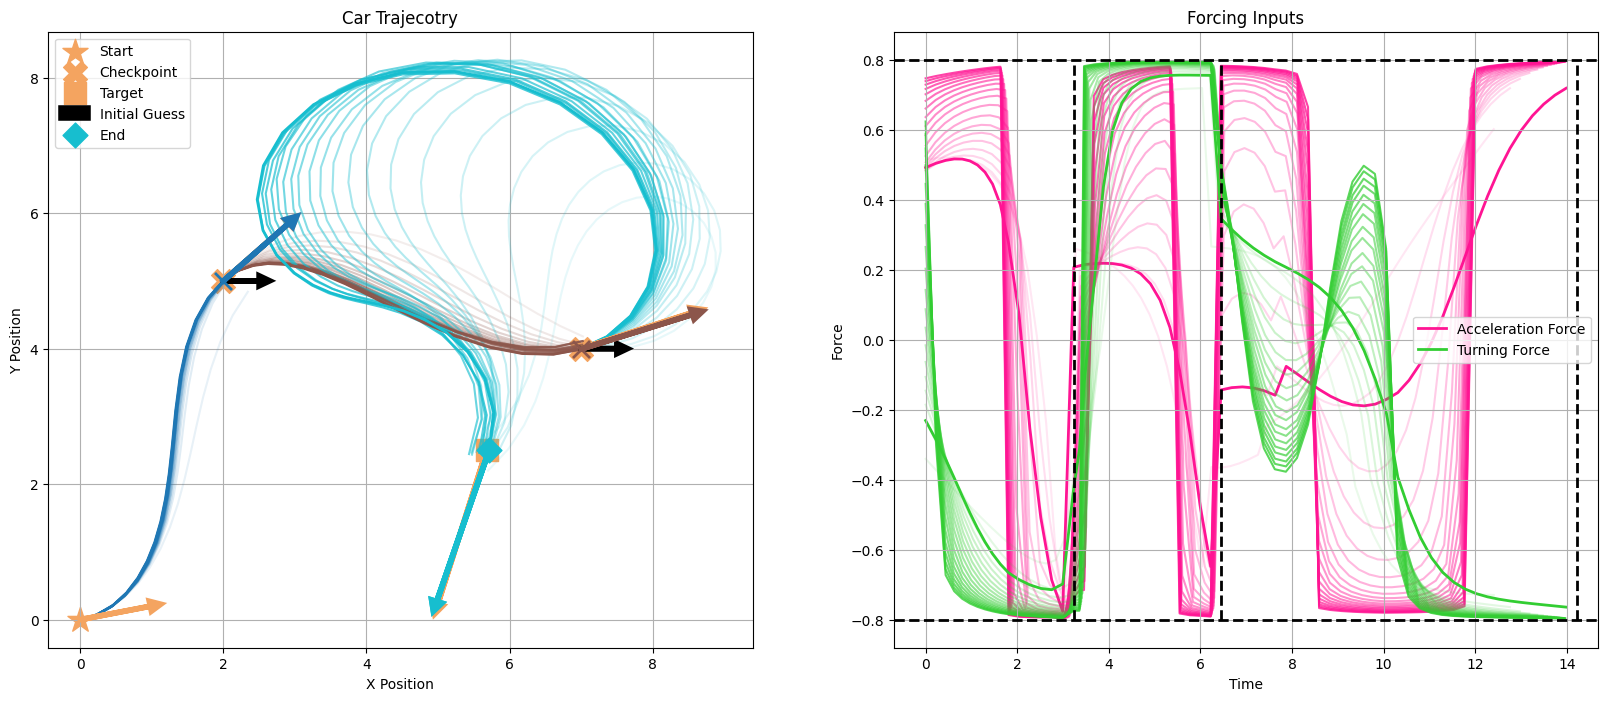

In [9]:
ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

plot_traj(V_mat, target, checkpoint_2d=checkpoint_2d, checkpoint_dof=checkpoint_dof, dof_init=checkpoint_dof_init, ax=ax1)
plot_forcing(F_cat, ts_cat, n_steps, ax=ax2)
plt.show()

In [10]:
v0 = pt.tensor([0, 0, 0.2, 1, 1, 0])
checkpoint_2d = pt.tensor([[3,  2],
                           [7, 5]])
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])
n_steps = pt.tensor([32, 32, 32])

checkpoint_dof_init = pt.tensor([[0,1,-0.5],
                                 [np.pi/2, 1,0.5]])

checkpoint_dof = nn.Parameter(checkpoint_dof_init.clone())

F_logits = [nn.Parameter(pt.zeros(n_steps[i], 3)) for i in range(n_steps.shape[0])]

print(f'Start: {v0.detach()}\n' +
      f'Checkpoint Guess: {pt.cat([checkpoint_2d, checkpoint_dof.detach()], dim=1)}\n'+
      f'Target: {target}\n'
    )

F_logits, F_true, checkpoint_dof, V_mat, ts_mat, loss_logs = optimizeMultiPath(v0, checkpoint_2d, target, checkpoint_dof, F_logits, iters=1000)

Start: tensor([0.0000, 0.0000, 0.2000, 1.0000, 1.0000, 0.0000])
Checkpoint Guess: tensor([[ 3.0000,  2.0000,  0.0000,  1.0000, -0.5000],
        [ 7.0000,  5.0000,  1.5708,  1.0000,  0.5000]])
Target: tensor([ 5.6807,  2.5029, -1.8625,  2.3750, -1.7500])

Iteration 50, Mean Position Dist: 0.797,  End Time: 14.475,  L2: 0.162,  Reverse Loss: 0.022
Iteration 100, Mean Position Dist: 0.443,  End Time: 15.289,  L2: 0.198,  Reverse Loss: 0.047
Iteration 150, Mean Position Dist: 0.365,  End Time: 15.129,  L2: 0.211,  Reverse Loss: 0.033
Iteration 200, Mean Position Dist: 0.298,  End Time: 15.105,  L2: 0.225,  Reverse Loss: 0.022
Iteration 250, Mean Position Dist: 0.238,  End Time: 15.120,  L2: 0.242,  Reverse Loss: 0.016
Iteration 300, Mean Position Dist: 0.188,  End Time: 15.144,  L2: 0.262,  Reverse Loss: 0.014
Iteration 350, Mean Position Dist: 0.149,  End Time: 15.155,  L2: 0.284,  Reverse Loss: 0.012
Iteration 400, Mean Position Dist: 0.135,  End Time: 15.119,  L2: 0.307,  Reverse Loss:

In [11]:
pt.tensor([V_mat[-1][i][-1:].tolist() for i in range(len(V_mat[-1])-1)]).squeeze(dim=1) - pt.cat([checkpoint_2d, checkpoint_dof], dim=1)

tensor([[ 3.7031e-03,  1.8132e-03,  6.2769e+00, -2.6064e-03,  5.4547e-03],
        [-3.6097e-04, -1.4772e-03,  1.4228e-03,  3.1233e-05,  4.4446e-03]],
       grad_fn=<SubBackward0>)

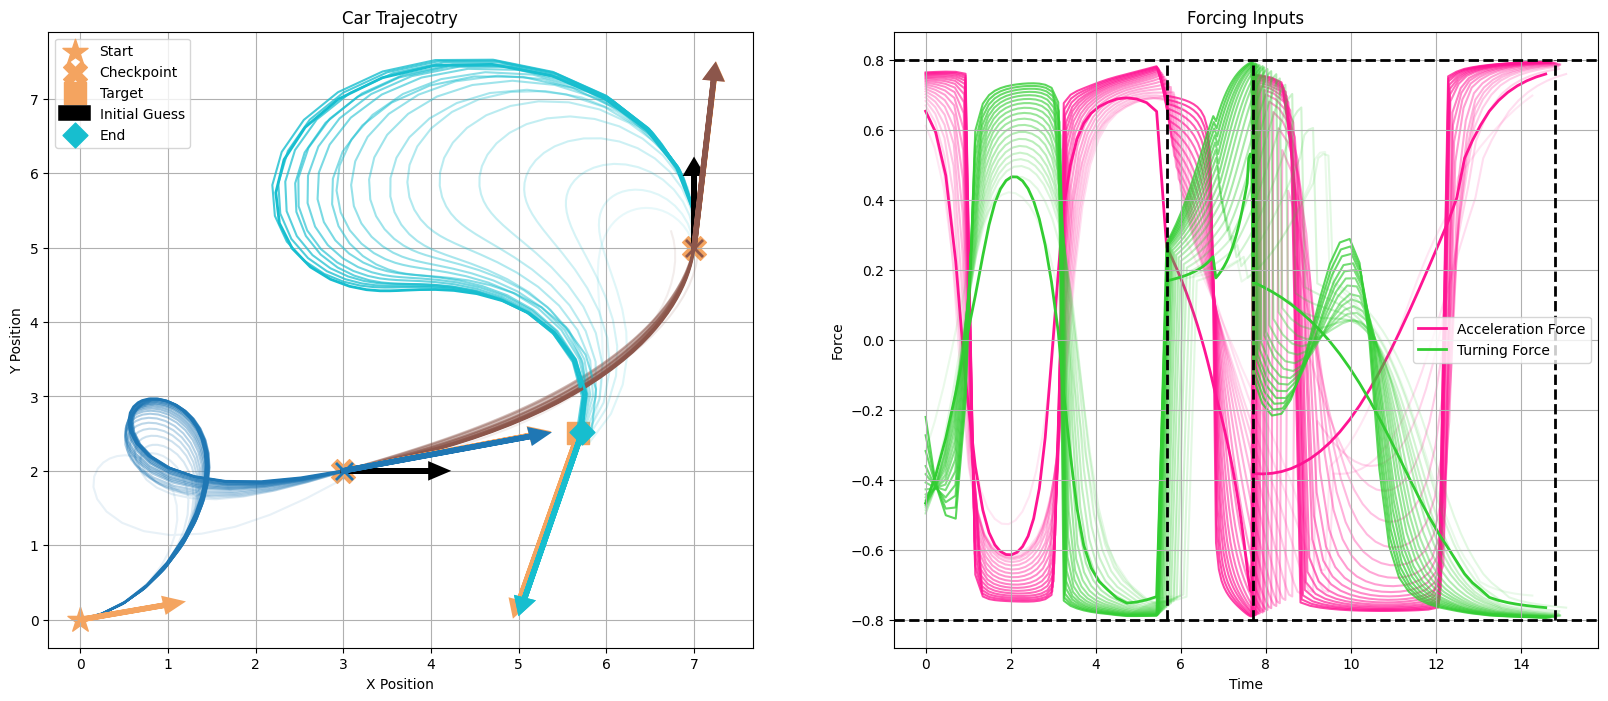

In [12]:
ts_cat = cat_ts(ts_mat)
F_cat = cat_F(F_true)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

plot_traj(V_mat, target, checkpoint_2d=checkpoint_2d, checkpoint_dof=checkpoint_dof, dof_init=checkpoint_dof_init, ax=ax1)
plot_forcing(F_cat, ts_cat, n_steps, ax=ax2)
plt.show()